### 1. Four classifier: original, one with only sleep as feature, one only train on sleep class and one only train on awake class.

### 2. For 231 and 222_1, sleep classifier performs better than the awake classifier. 

### 3. For original classifier, the accuracy for sleep class is lower than that for awake class

### 4. Consider stratified both sleep class and label

In [48]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator

from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import jj_basic_fn as JJ
from sklearn import ensemble
import seaborn as sns
%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv


import jj_basic_fn as JJ
from hyperparams import Hyperparams as hp
from patient import patient
import prep
import plot_funcs
import modules

#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:



features_list = ['delta', 'beta','low_gamma']
plot_3d_var_list = ['beta2', 'beta4','low_gamma3']


import pickle
#p231, p222_1, p222_2, p222_3 = pickle.load(open(hp.prepath_pat + '231' +'_trained.p', "rb" )),pickle.load(open(hp.prepath_pat + '222_1' +'_trained.p', "rb" )), pickle.load(open(hp.prepath_pat + '222_2' +'_trained.p', "rb" )), pickle.load(open(hp.prepath_pat + '222_3' +'_trained.p', "rb" ))
p231 = pickle.load(open(hp.prepath_pat + '231' +'_trained.p', "rb" ))


## 1. Data loading

### What the data looks like

In [50]:
pat = p231
display(pd.DataFrame(p231.features))
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)


,filename,region_start_time,sleep,delta1,delta2,...,i34,epoch,label,id,if_stimulated
647,1.313099e+17,2017-02-07 04:00:28.972800,1.0,52.540879,43.652166,...,0.0,0,True,231,False
648,1.313099e+17,2017-02-07 10:00:26.985600,0.0,67.371989,36.895066,...,0.0,0,True,231,False
649,1.313100e+17,2017-02-07 16:00:26.035200,0.0,99.857643,43.743936,...,1.0,0,True,231,False
650,1.313103e+17,2017-02-07 22:00:12.988800,0.0,129.677420,85.919986,...,2.0,0,True,231,False
651,1.313103e+17,2017-02-08 04:00:12.038400,1.0,91.679727,60.534557,...,0.0,0,True,231,False
...,...,...,...,...,...,...,...,...,...,...,...
1535,1.316288e+17,2018-02-11 15:51:35.971200,0.0,104.142656,43.925946,...,1.0,11,False,231,False
1536,1.316296e+17,2018-02-11 21:51:24.998400,0.0,113.162000,50.395396,...,1.0,11,False,231,False
1537,1.316296e+17,2018-02-12 03:51:23.011200,1.0,225.536331,153.708886,...,8.0,11,False,231,False
1538,1.316296e+17,2018-02-12 09:51:21.974400,0.0,85.753303,34.006378,...,0.0,11,False,231,False


## 2. Building Classifiers
### Fitting 7 classfier to the training data and tune the hyperparameter using 10-fold cross-validation. Evaluate the performance of each classifier using test data

### 1:'Logistic Regression' (regulation type, regulation parameter)
### 2: 'SVM' (kernel type, degreee, regulation type, regulation parameter)
### 3: 'Gaussian Naive Bayes classifier'
### 4:'Linear Discriminant Analysis'
### 5:'Decision Tree' (criterion for splliting, max depth, min sample per leaf)
### 6:'Random Forest' (criterion for splliting, number of trees, number of features used in each  tree, max depth, min sample per leaf)
### 7:'Gradient Boosting' (number of estimator, number of samples used in each estimator, max depth, min sample per leaf, learning rate)

## 3. Classifier Performance

### Performace Overview of each Classifier

### The confusion matrix and ROC of Logistic Regression (the best classifier in this case)

Confusion matrix, without normalization


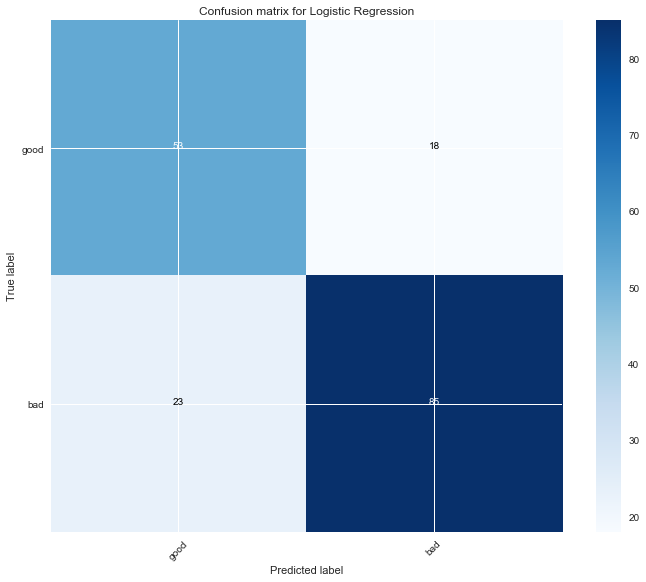

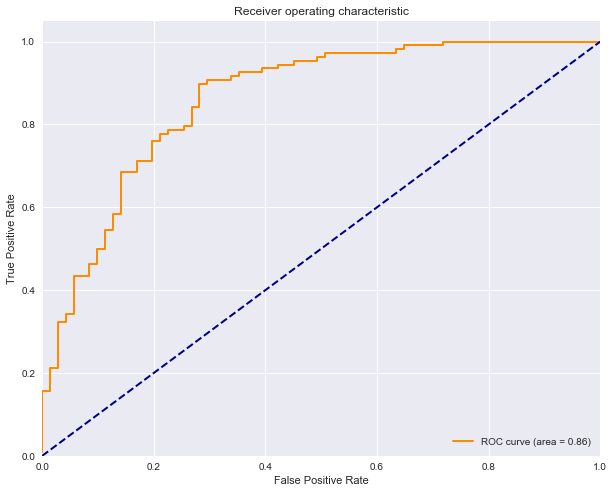

In [6]:
JJ.estimator_performance(1, X_test, y_test, pat = pat, if_plot_c = 1, if_plot_roc = 1)

### ROC curve for all classifiers

In [1]:
JJ.scores_estimators(X_test, y_test, pat = pat)

NameError: name 'JJ' is not defined

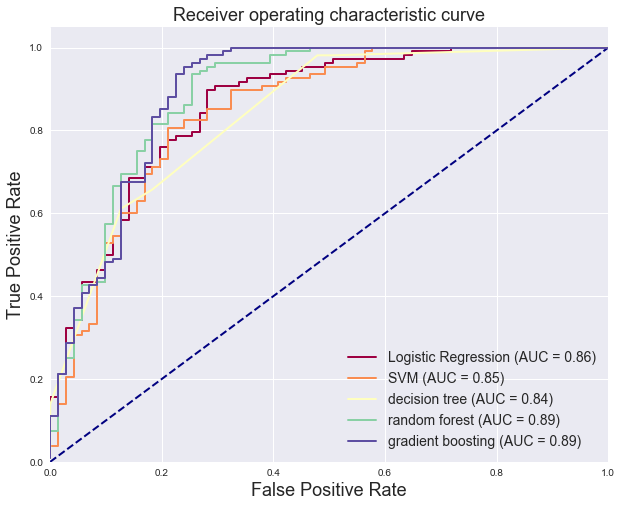

In [7]:
plot_funcs.plot_roc_all(X_test, y_test, pat =pat)

In [4]:
plot_funcs.plot_roc_all(X_test, y_test, pat =p222_1)

NameError: name 'X_test' is not defined

### Ensemble SVM, Logistic Regression, Random Forest and Gradient Boosting using hard vote

In [8]:

X_train, X_test, y_train, y_test = JJ.get_ml_data(data, patid, if_scaler = 1, if_remove_icd = 1)
#parameter_tuning(X_train, X_test, y_train, y_test, classifier = 1, C_range_num = 100, if_save = 1)

print("The accuracy for ensemble model is")
JJ.ensemble_model(X_train, y_train, X_test, y_test, patid = patid,if_save = 0)

AttributeError: module 'jj_basic_fn' has no attribute 'get_ml_data'

## 4. Feature Importance

### Feature Importance for Logistic regression

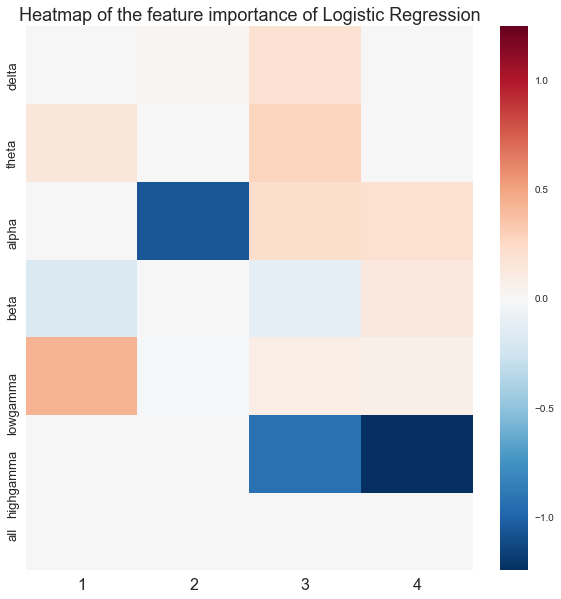

In [11]:
plot_funcs.feature_importance(pat,1)

### Feature Importance for Gradient Boosting

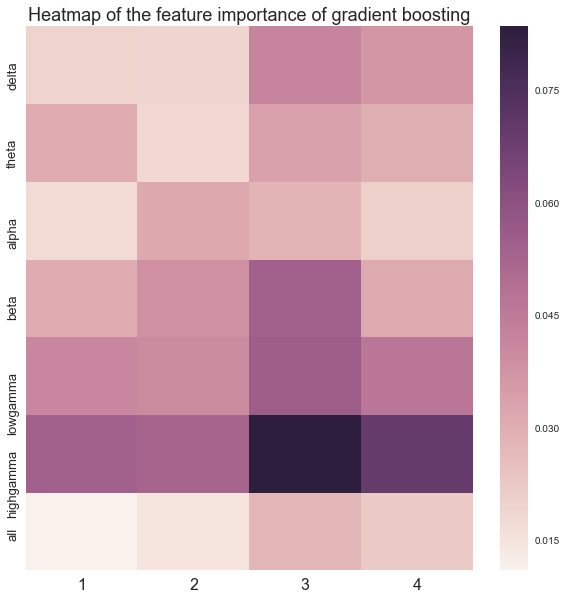

In [13]:
plot_funcs.feature_importance(pat,7)

## 5. Data visualization

## Pairwise features scatter plot

### Each data point corresponds to a .dat file. Red points means it is in a good epoch, and blue points means it is in a bad epoch.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data_ml = JJ.get_scatter_plot_data(data, patid)
sns.set(font_scale=2)
colors = ["baby pink", "neon blue", "bright red", "sky"]
g = sns.pairplot(data_ml, hue="label_sti", size = 6, vars=JJ.get_variable_name(features_list), plot_kws={"s": 5},palette=sns.xkcd_palette(colors))
plt.show()

### 3D scatter plot

In [ ]:
%matplotlib notebook
sns.set(font_scale=1)

JJ.scatter_plot_3d(data,patid, var_list = plot_3d_var_list)
